In [1]:
import os
import cv2

import torch
from loguru import logger
from mmpose.apis import (
    inference_topdown,
    init_model,
)
from mmpose.apis.inference import inference_top_down_pose_model
import json
import numpy as np
from tqdm import tqdm

/private/home/taoshaf/miniforge3/envs/vitpose/lib/python3.9/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


In [2]:
import torch, detectron2
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
import matplotlib.pyplot as plt

In [4]:
device = "cuda"

In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

In [6]:
VIT_DIR = "/private/home/taoshaf/Documents/python/ViTPose"
VITPOSE_CKPT_PTH = "/private/home/taoshaf/checkpoints/vitpose/vitpose_h_wholebody/wholebody.pth"
VITPOSE_CFG = os.path.join(
    VIT_DIR,
    "configs/wholebody/2d_kpt_sview_rgb_img/topdown_heatmap/coco-wholebody/ViTPose_huge_wholebody_256x192.py",
)

In [7]:
body_idxs = list(range(23))
hand_idxs = list(range(91, 133))

In [8]:
def build_vitpose(device):
    detector = init_model(VITPOSE_CFG, VITPOSE_CKPT_PTH, device=device)
    return detector

In [9]:
predictor = DefaultPredictor(cfg)

In [10]:
detector = build_vitpose(device)

04/27 19:52:49 - mmengine - WARNING - 
The config you are using is outdated. The following section of the config:
```
model=dict(
    ...,
    head=dict(
        extra=dict(final_conv_kernel=1),
        ...),
```
should be updated to
```
model=dict(
    ...,
    head=dict(
        final_layer=dict(kernel_size=1),
        ...),
```
For more information, please refer to https://mmpose.readthedocs.io/en/latest/guide_to_framework.html#step3-model
Loads checkpoint by local backend from path: /private/home/taoshaf/checkpoints/vitpose/vitpose_h_wholebody/wholebody.pth


/private/home/taoshaf/miniforge3/envs/vitpose/lib/python3.9/site-packages/mmengine/runner/checkpoint.py:347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch

In [11]:
data_dir = "/private/home/taoshaf/data/egoexo4d/uniandes_bouldering_012_43/"
data_dir = "/private/home/taoshaf/data/egoexo4d/uniandes_dance_019_15/"

In [ ]:
for cam in ["cam02", "cam03", "cam04"]:
    img_dir = os.path.join(data_dir, cam)
    img_files = sorted(os.listdir(img_dir))

    keypoints = {}
    bboxes = {}
    for idx, img_file in tqdm(enumerate(img_files)):
        img_path = os.path.join(img_dir, img_file)
        img = cv2.imread(img_path)[:, :, ::-1]

        det = predictor(img[:, :, ::-1])
        if len(det["instances"].pred_boxes.tensor) == 0:
            continue
        bbox = det["instances"].pred_boxes.tensor[0].to(int).cpu().numpy()
        H, W = img.shape[:2]
        xc, yc = (bbox[:2] + bbox[2:]) // 2
        xw, yh = (1.1 * (bbox[2:] - bbox[:2])).astype(int)
        bbox = [max(0, xc - xw // 2), max(0, yc - yh // 2), min(W - 1, xc + xw // 2), min(H - 1, yc + yh // 2)]
        results, _ = inference_topdown(detector, img_path, person_results=[{"bbox": bbox}], format="xyxy")
        kpts = results[0]["keypoints"]
        bboxes[idx] = np.array(bbox).astype(int).tolist()
        keypoints[idx] = np.array(kpts).tolist()

    bbox_dir = os.path.join(data_dir, "bboxes")
    if not os.path.exists(bbox_dir):
        os.makedirs(bbox_dir)
    with open(os.path.join(bbox_dir, f"{cam}.json"), "w") as f:
        json.dump(bboxes, f)

    keypoint_dir = os.path.join(data_dir, "keypoints")
    if not os.path.exists(keypoint_dir):
        os.makedirs(keypoint_dir)
    with open(os.path.join(keypoint_dir, f"{cam}.json"), "w") as f:
        json.dump(bboxes, f)

In [12]:
cam = "cam01"
img_dir = os.path.join(data_dir, cam)
img_file = sorted(os.listdir(img_dir))[0]

In [13]:
img_path = os.path.join(img_dir, img_file)
img = cv2.imread(img_path)[:, :, ::-1]

In [14]:
det = predictor(img[:, :, ::-1])
bbox = det["instances"].pred_boxes.tensor[0].to(int).cpu().numpy()

/private/home/taoshaf/miniforge3/envs/vitpose/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647350383/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


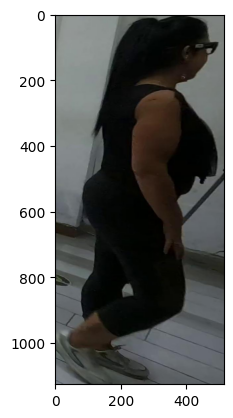

In [15]:
plt.imshow(img[bbox[1]:bbox[3], bbox[0]:bbox[2]])

In [ ]:
results, _ = inference_top_down_pose_model(detector, img, person_results=[{"bbox": bbox}], format="xyxy")
kpts = results[0]["keypoints"]

body_kpts = kpts[body_idxs]
hand_kpts = kpts[hand_idxs]

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(img[bbox[1] : bbox[3], bbox[0] : bbox[2]])
plt.scatter(
    body_kpts[body_kpts[:, 2] >= 0.7, 0] - bbox[0],
    body_kpts[body_kpts[:, 2] >= 0.7, 1] - bbox[1],
    c="red",
    s=10,
)
plt.scatter(
    hand_kpts[hand_kpts[:, 2] >= 0.8, 0] - bbox[0],
    hand_kpts[hand_kpts[:, 2] >= 0.8, 1] - bbox[1],
    c="blue",
    s=10,
)

In [ ]:
# annos = np.array([[anno["x"], anno["y"]] for anno in annos["annotation2D"][cam].values()])

In [ ]:
# xmin, ymin = annos.min(axis=0)
# xmax, ymax = annos.max(axis=0)

# h = int(1.25 * (ymax - ymin))
# w = int(1.25 * (xmax - xmin))

# xc = int(xmin + xmax) // 2
# yc = int(ymin + ymax) // 2

# bbox = [xc - w // 2, yc - h // 2, xc + w // 2, yc + h // 2]

In [ ]:
kpts = results[0]["keypoints"][:23]

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(img[bbox[1] : bbox[3], bbox[0] : bbox[2]])
plt.scatter(kpts[kpts[:, 2] >= 0.7, 0] - bbox[0], kpts[kpts[:, 2] >= 0.7, 1] - bbox[1])

In [ ]:
img_path = f"{data_dir}/cam02/{img_idxs}.jpg"
img = cv2.imread(img_path)[:, :, ::-1]

In [ ]:
bbox = [1200, 1325, 1725, 1825]
results, _ = inference_top_down_pose_model(detector, img, person_results=[{"bbox": bbox}], format="xyxy")
kpts = results[0]["keypoints"][:23]

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(img[bbox[1] : bbox[3], bbox[0] : bbox[2]])
plt.scatter(kpts[kpts[:, 2] >= 0.75, 0] - bbox[0], kpts[kpts[:, 2] >= 0.75, 1] - bbox[1])

In [ ]:
img_path = f"{data_dir}/cam03/{img_idxs}.jpg"
img = cv2.imread(img_path)[:, :, ::-1]

In [ ]:
bbox = [400, 1475, 1250, 2100]
results, _ = inference_top_down_pose_model(detector, img, person_results=[{"bbox": bbox}], format="xyxy")
kpts = results[0]["keypoints"][:23]

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(img[bbox[1] : bbox[3], bbox[0] : bbox[2]])
plt.scatter(kpts[kpts[:, 2] >= 0.75, 0] - bbox[0], kpts[kpts[:, 2] >= 0.75, 1] - bbox[1])

In [ ]:
img_path = f"{data_dir}/cam04/{img_idxs}.jpg"
img = cv2.imread(img_path)[:, :, ::-1]

In [ ]:
bbox = [675, 2050, 1075, 2350]
# bbox = [1185, 2450, 1540, 3025]
results, _ = inference_top_down_pose_model(detector, img, person_results=[{"bbox": bbox}], format="xyxy")
kpts = results[0]["keypoints"][:23]

In [ ]:
plt.imshow(img[bbox[1] : bbox[3], bbox[0] : bbox[2]])
plt.scatter(kpts[kpts[:, 2] >= 0.75, 0] - bbox[0], kpts[kpts[:, 2] >= 0.75, 1] - bbox[1])

In [ ]:
kpts